In [147]:
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
import pandas as pd

from skimage.filters import try_all_threshold, threshold_otsu, sobel, gaussian
from skimage.restoration import denoise_bilateral
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.feature import canny

%matplotlib inline  

In [2]:
print(cv.__version__, cv.__spec__)
# print(cv.getBuildInformation())

4.6.0 ModuleSpec(name='cv2', loader=<_frozen_importlib_external.SourceFileLoader object at 0x0000018514C54940>, origin='C:\\Users\\YX\\AppData\\Roaming\\Python\\Python310\\site-packages\\cv2\\__init__.py', submodule_search_locations=['C:\\Users\\YX\\AppData\\Roaming\\Python\\Python310\\site-packages\\cv2'])


In [14]:
z_df = pd.read_csv('../raw_data/depths.csv',index_col = 0)
z_df.describe()

,z
count,22000.000000
mean,506.453318
std,208.605991
min,50.000000
25%,352.000000
50%,513.000000
75%,671.000000
max,959.000000


In [15]:
z_df.head()

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


In [3]:
path_train = '../raw_data/train/'
path_test = '../raw_data/test/'

Data Exploration

In [51]:
def show_image(image, filename = img_name, cmap_type = 'gray', **kwargs):
    """show image"""
    plt.imshow(image, cmap = cmap_type )
    for a in kwargs:
        title = str(z_df.loc[img_name,'z']) + kwargs[a]
    plt.title(title)

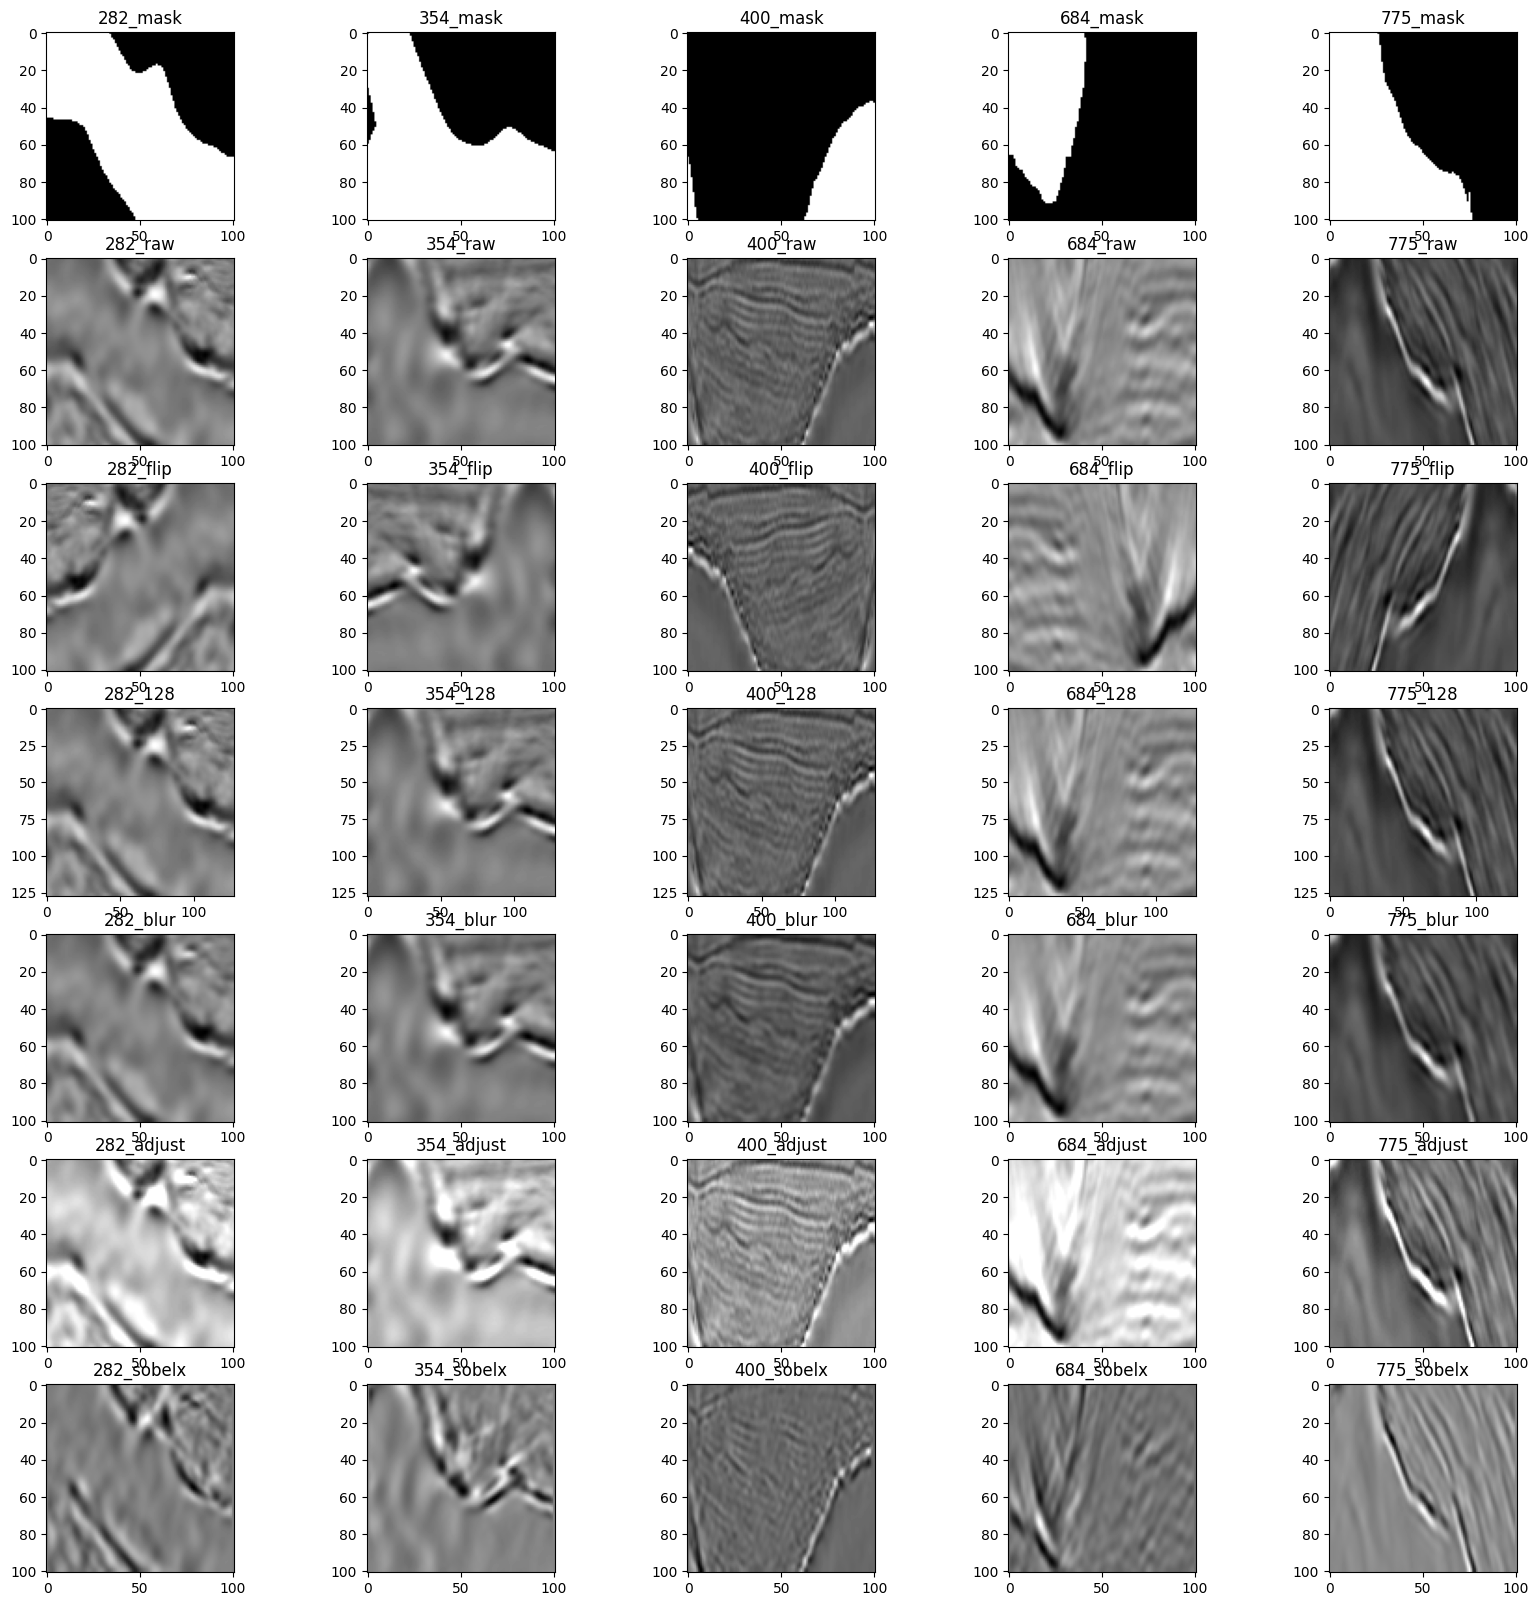

In [70]:
ids= ['0a1742c740','1f1e11aee4','5b7c160d0d','4ed2467e7c','5f3b26ac68']
alpha=1.5
beta=0.5
plt.figure(figsize=(20,20))
row = 7
for j, img_name in enumerate(ids):
    q = j+1
    img = cv.imread(path_train + '/images/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    img_mask = cv.imread(path_train + '/masks/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
#     img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # do not need, coz all channels equal
    # flip right-left
    img_flip = cv.flip(img, flipCode=1) 
    
    # resize
    img_128 = cv.resize(img, dsize=(128, 128), interpolation=cv.INTER_CUBIC) 
    
    # blur
    img_blur = cv.blur(img, ksize=(3, 3)) 
    
    # Adjust brightness, contrast
    img_adj = cv.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
    
    #remove horizontal lines
    sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)

    plt.subplot(row,len(ids),q+len(ids) )
    show_image(img, suffix = '_raw') #title = str(z_df.loc[img_name,'z']),cmap_type = 'gray',

    plt.subplot(row,len(ids),q)
    show_image(img_mask, suffix = '_mask')

    plt.subplot(row,len(ids),q+2* len(ids))
    show_image(img_flip, suffix = '_flip')
    
    plt.subplot(row,len(ids),q+3* len(ids))
    show_image(img_128, suffix = '_128')
    
    plt.subplot(row,len(ids),q+4* len(ids))
    show_image(img_blur, suffix = '_blur')
    
    plt.subplot(row,len(ids),q+5* len(ids))
    show_image(img_adj, suffix = '_adjust')   
    
    plt.subplot(row,len(ids),q+6* len(ids))
    show_image(sobelx, suffix = '_sobelx')   

In [ ]:
# https://docs.opencv.org/4.x/d5/d0f/tutorial_py_gradients.html
# gradient filters


In [162]:
def plot_Canny(img, mask,img_name, col = 4, **kwargs):
    """detect edge with Canny & Sobel"""
#     canny_edges = cv.Canny(img,100,200)

    
    #remove horizontal lines using Sobel
    sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
    
    # edge detection using Canny
    for a in kwargs:
        sigma = kwargs[a]
    canny_edges = canny(img, sigma = sigma)
    
    plt.figure(figsize=(20,20))
    
    plt.subplot(1,col,2)
    show_image(img, suffix = '_raw')
    
    plt.subplot(1,col,1)
    show_image(img_mask, suffix = '_mask')    
    
    plt.subplot(1,col,3)
    show_image(canny_edges, suffix = '_edge') 
    
    plt.subplot(1,col,4)
    show_image(sobelx, suffix = '_sobelx')

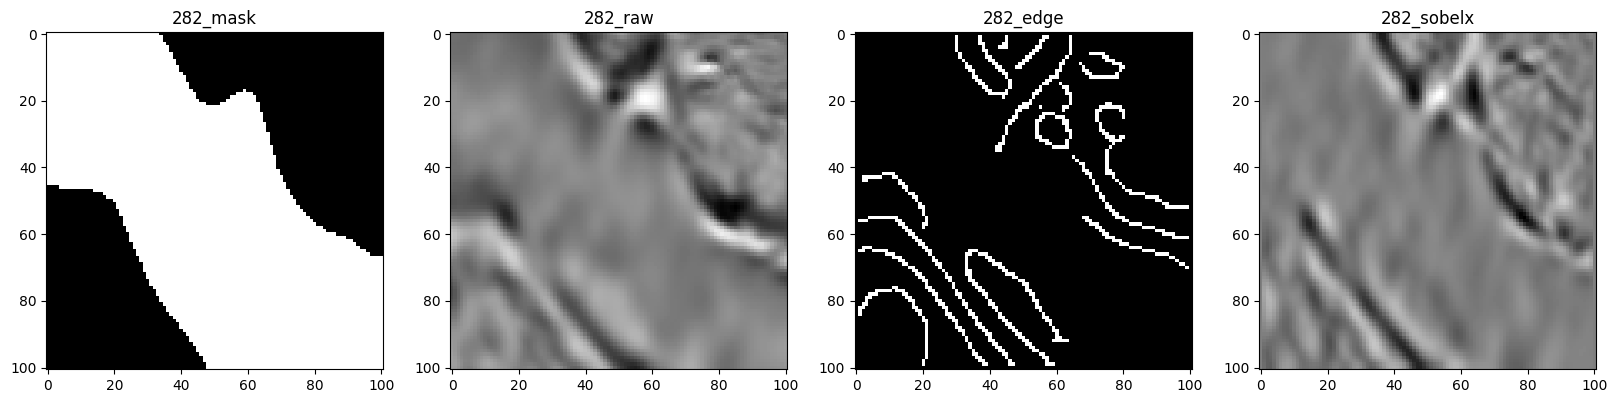

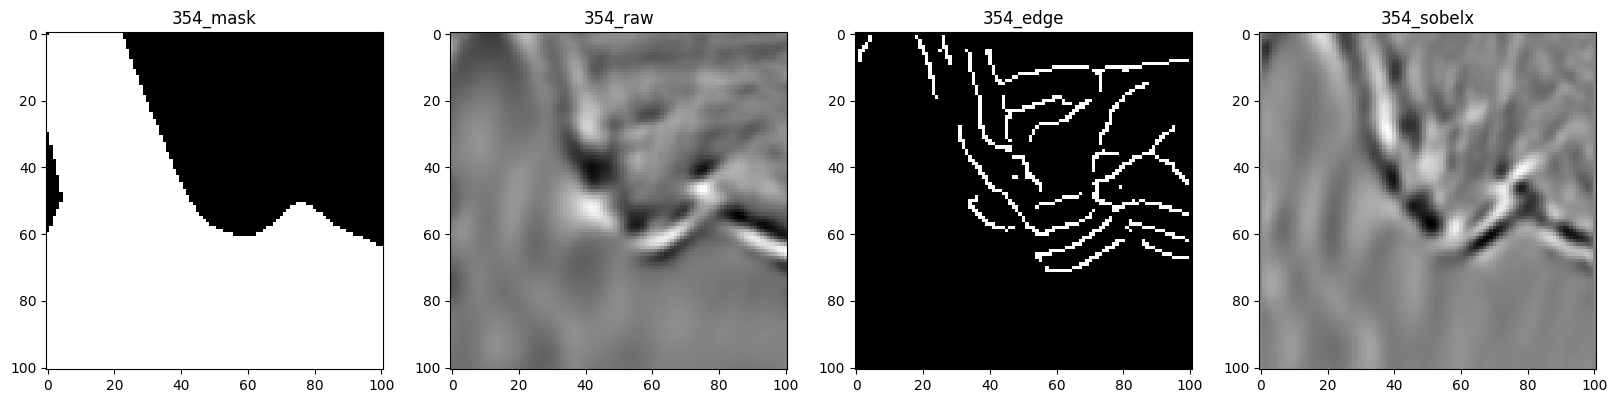

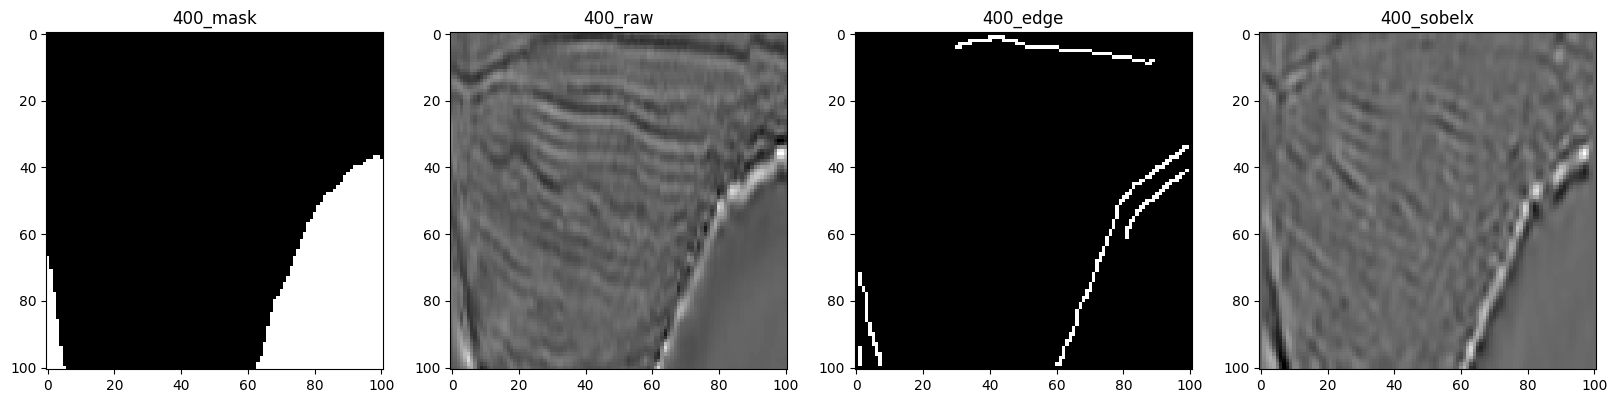

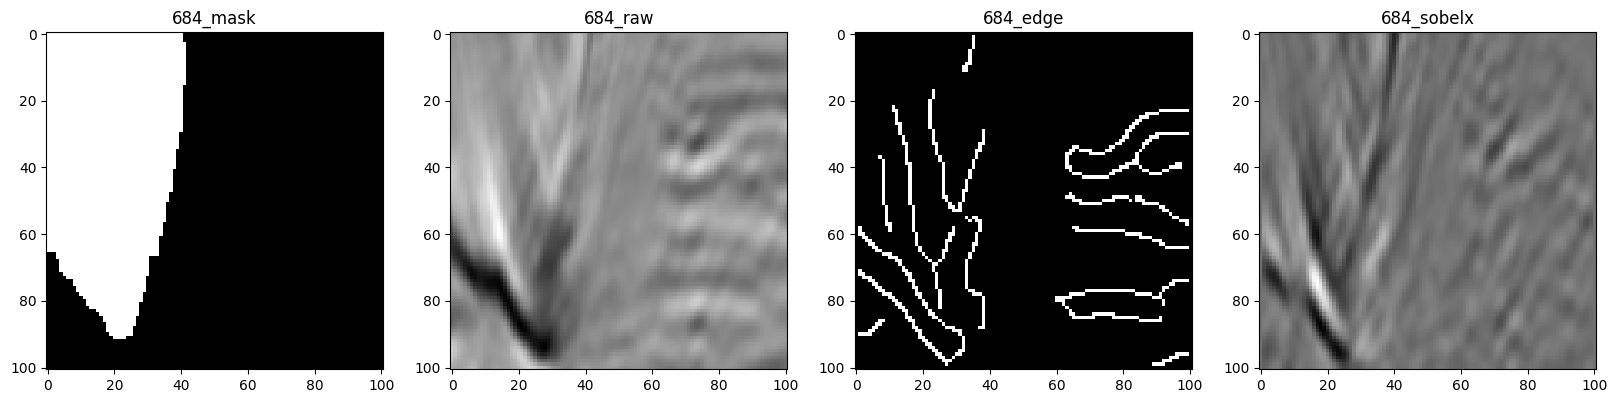

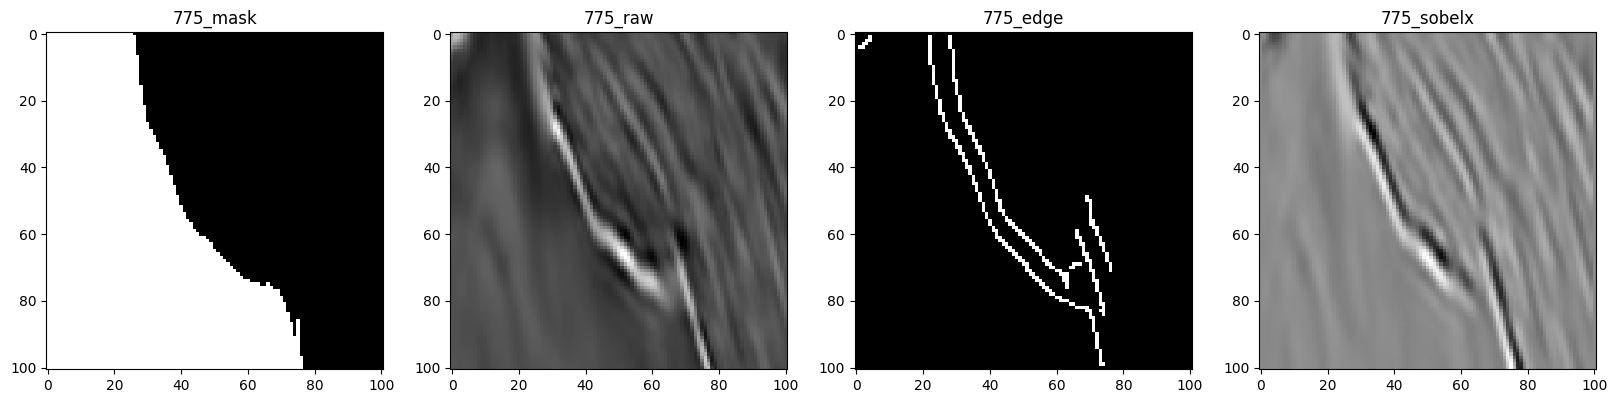

In [166]:
for img_name in ids:
    img = cv.imread(path_train + '/images/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    img_mask = cv.imread(path_train + '/masks/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    plot_Canny(img, img_mask, img_name, sigma = 2.5)

In [68]:
def plot_corner(img_name):
    """corner detection"""
    img = cv.imread(path_train + '/images/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    #remove horizontal lines
    corners = cv.goodFeaturesToTrack(img,25,0.01,10)
    corners = np.int0(corners)
    for i in corners:
        x,y = i.ravel()
        cv.circle(img,(x,y),3,255,-1)
    show_image(img, suffix = '_corner')    

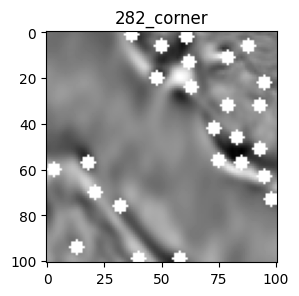

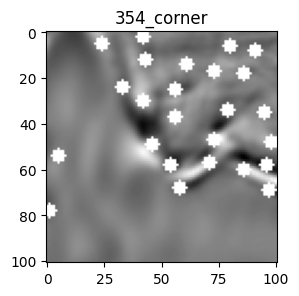

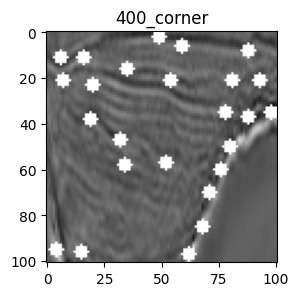

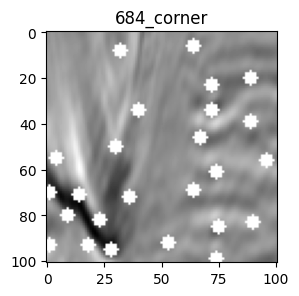

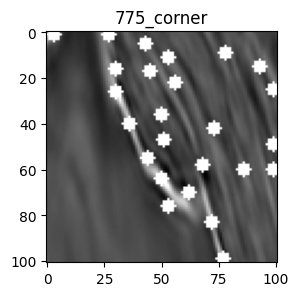

In [167]:
for img_name in ids:
    plt.figure(figsize = (3,3))
    plot_corner(img_name)

corner detection identifies salt boundary with a depth shallower than 500 m

In [115]:
def plot_gaussian(img_name):
    """thresholding for background and content, works best in high-contrast images"""
    img = cv.imread(path_train + '/images/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    gaussian_img = gaussian(img, channel_axis = 0)
#     gaussian_img = cv.GaussianBlur(img, (5,5), 0)
    
    fig = plt.figure(figsize=(20,10))
      
    plt.subplot(1,4,1)
    show_image(img, suffix = '_raw') 
   
    ax1 = fig.add_subplot(1,4,2)
    ax1.hist(img.ravel(), bins = 256)
    ax1.set_xlim(0, 255)
    ax1.set_title(str(z_df.loc[img_name,'z']) + '_histogram') 
    ax1.set_aspect(1 / ax1.get_data_ratio())
    
    plt.subplot(1,4,3)
    show_image(gaussian_img, suffix = '_gaussian')

    ax2 = fig.add_subplot(1,4,4)
    ax2.hist(255*gaussian_img.ravel(), bins = 256)
    ax2.set_xlim(0, 255)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_title(str(z_df.loc[img_name,'z']) + '_gaussian_histogram') 
    ax2.set_aspect(1 / ax2.get_data_ratio())


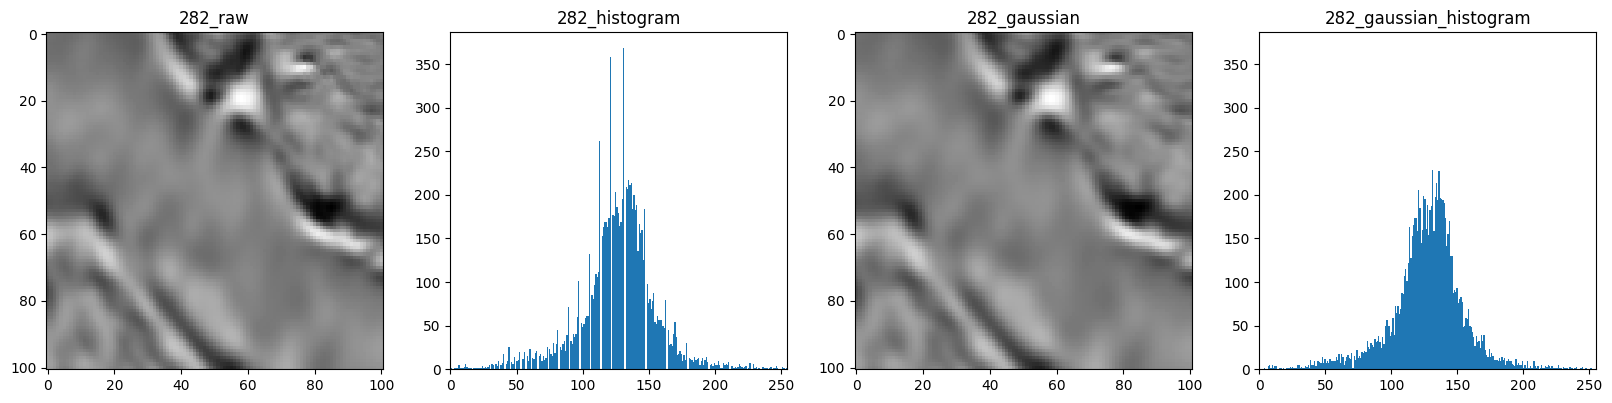

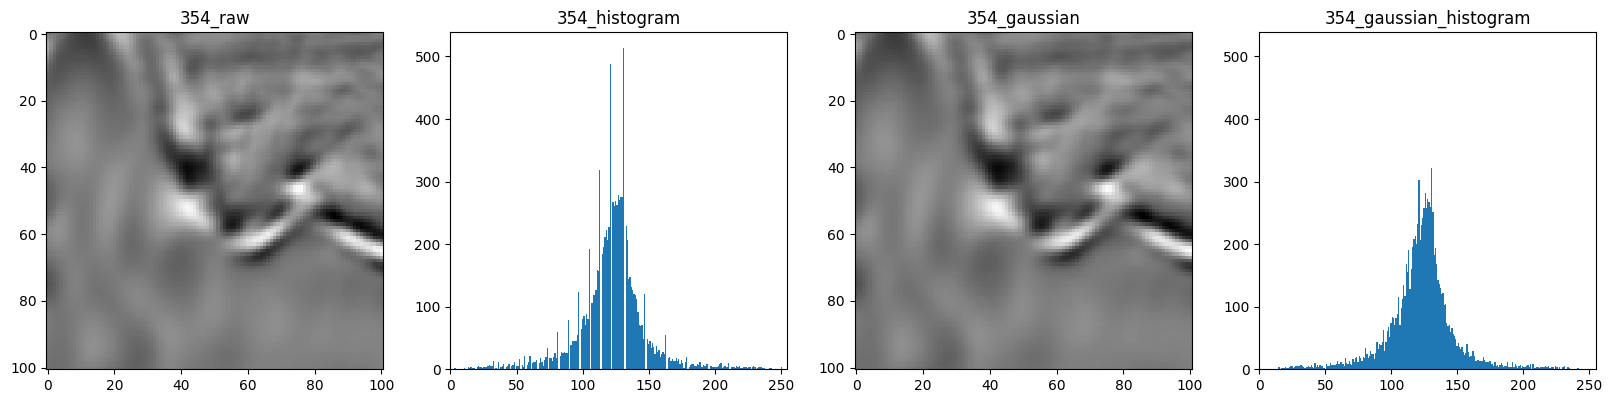

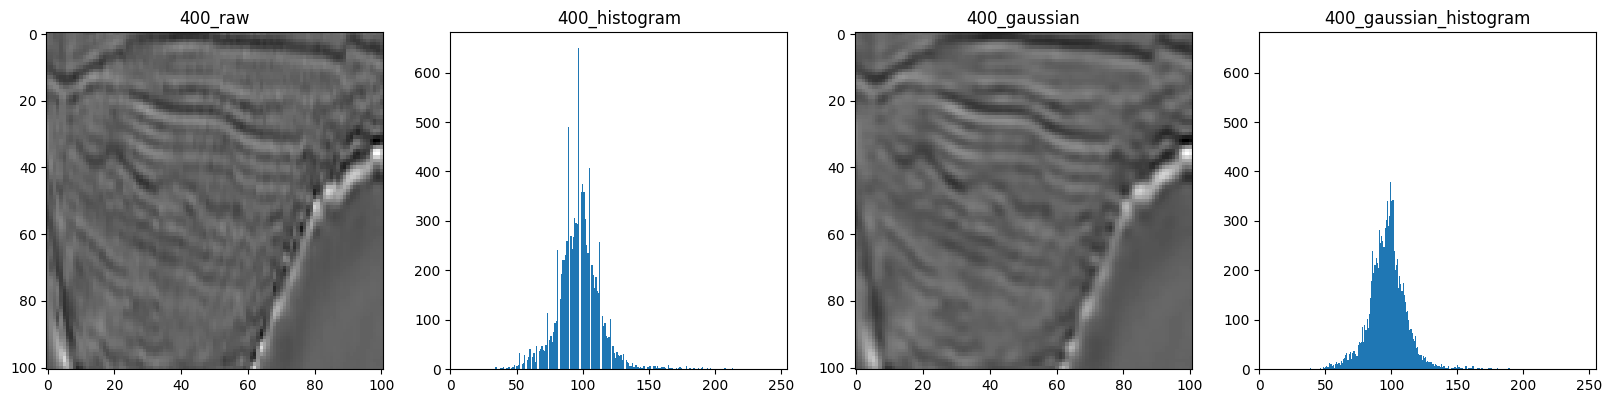

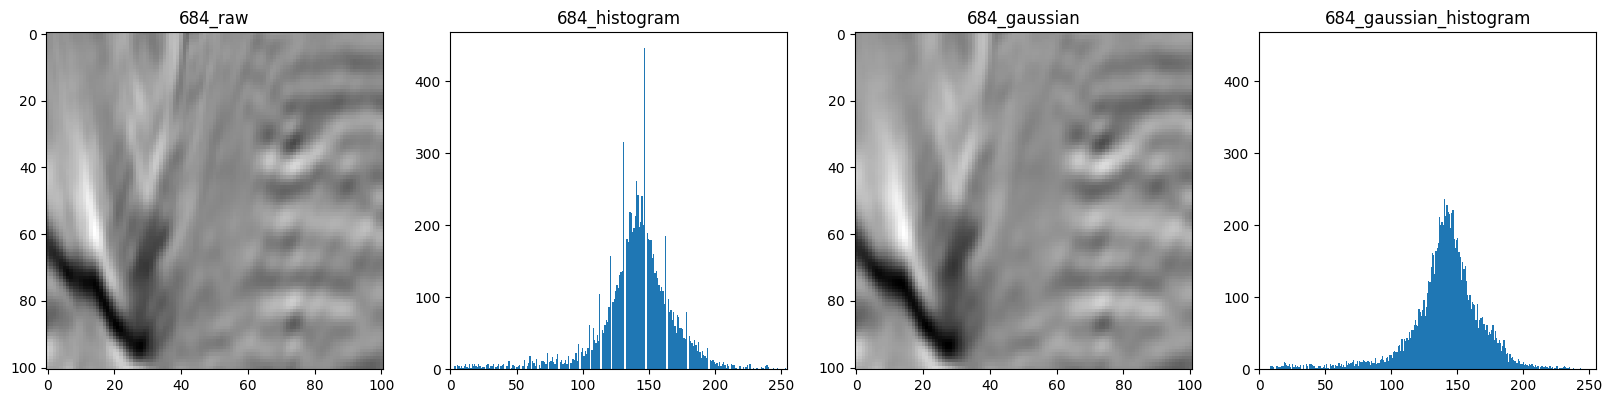

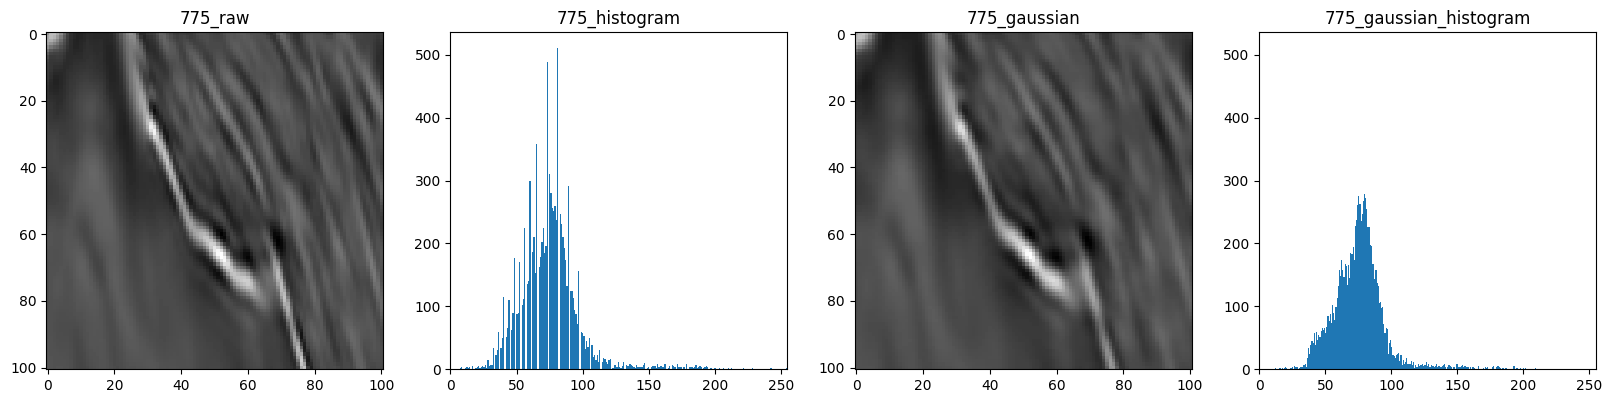

In [116]:
for img_name in ids:
    plot_gaussian(img_name)

Gaussian filter removes spikes in histogram

In [143]:
def plot_binary(img_name, thresh):
    """thresholding for background and content, works best in high-contrast images"""
    img = cv.imread(path_train + '/images/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    mask = cv.imread(path_train + '/masks/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    binary = img > thresh
    thresh_otsu = threshold_otsu(img)
    print(thresh_otsu)
    binary_otsu = img > thresh_otsu
    
    plt.figure(figsize=(20,10))
       
    plt.subplot(1,3,1)
    show_image(img, suffix = '_raw') 
    
    plt.subplot(1,3,2)
    show_image(binary, suffix =  '_binary')
    
    plt.subplot(1,3,3)
    show_image(binary_otsu, suffix =  '_otsu')

121
113
97
121
108


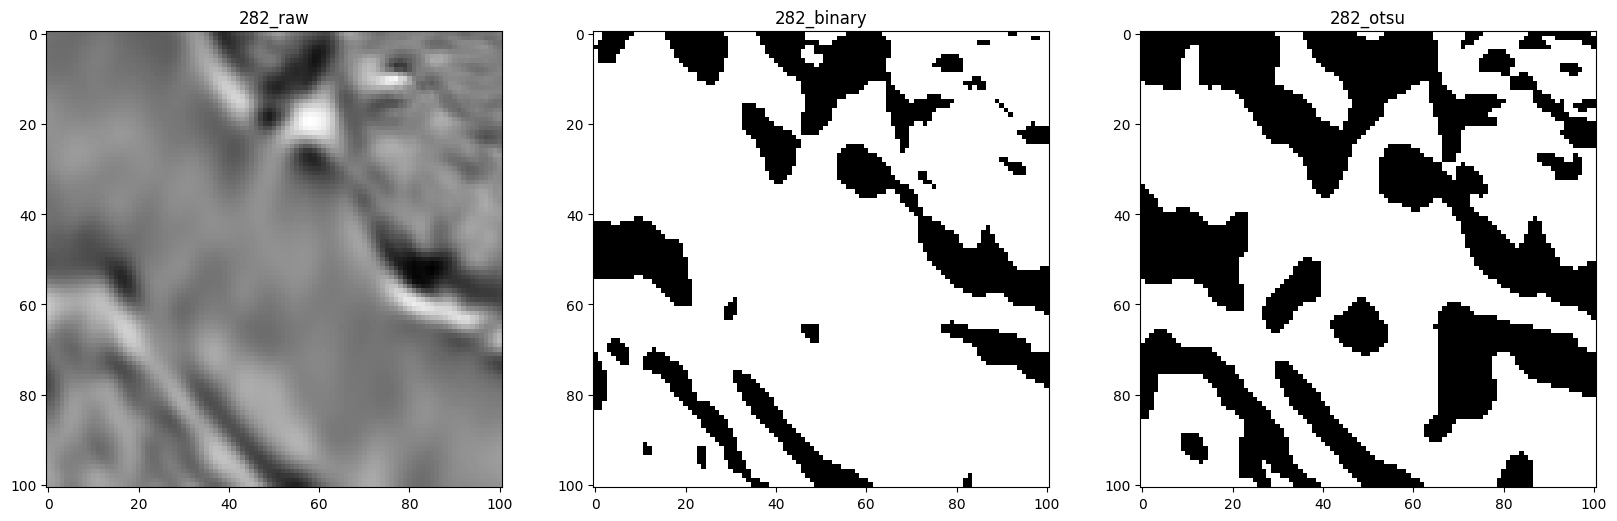

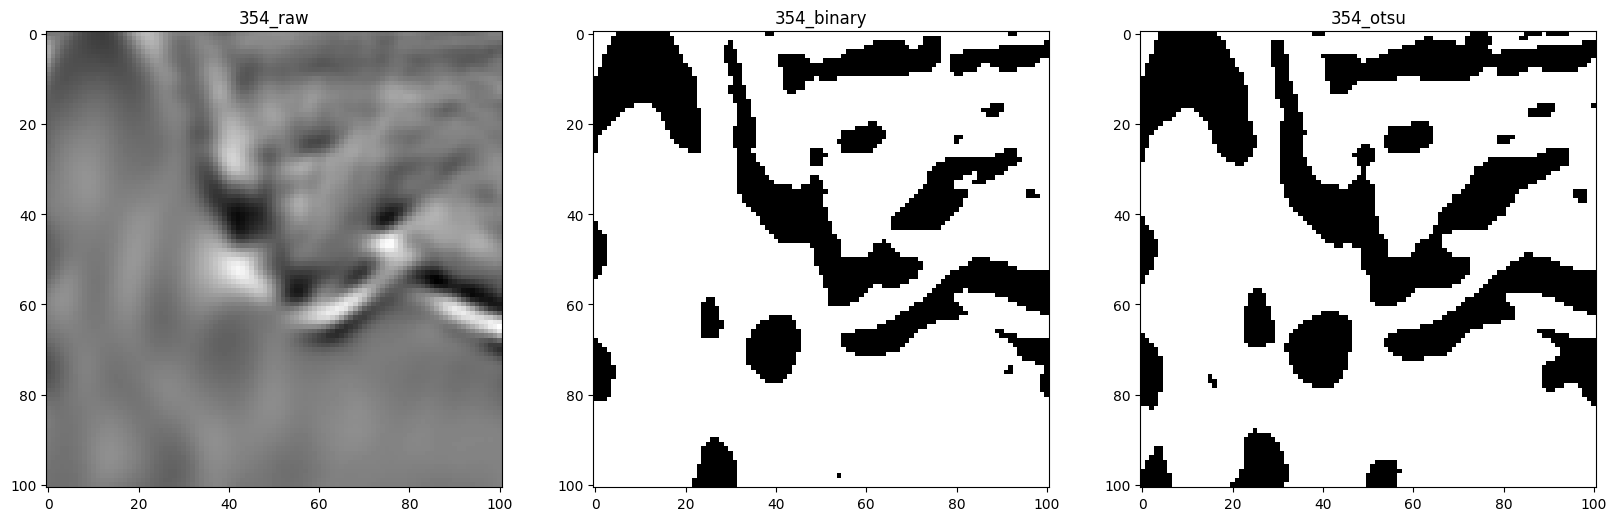

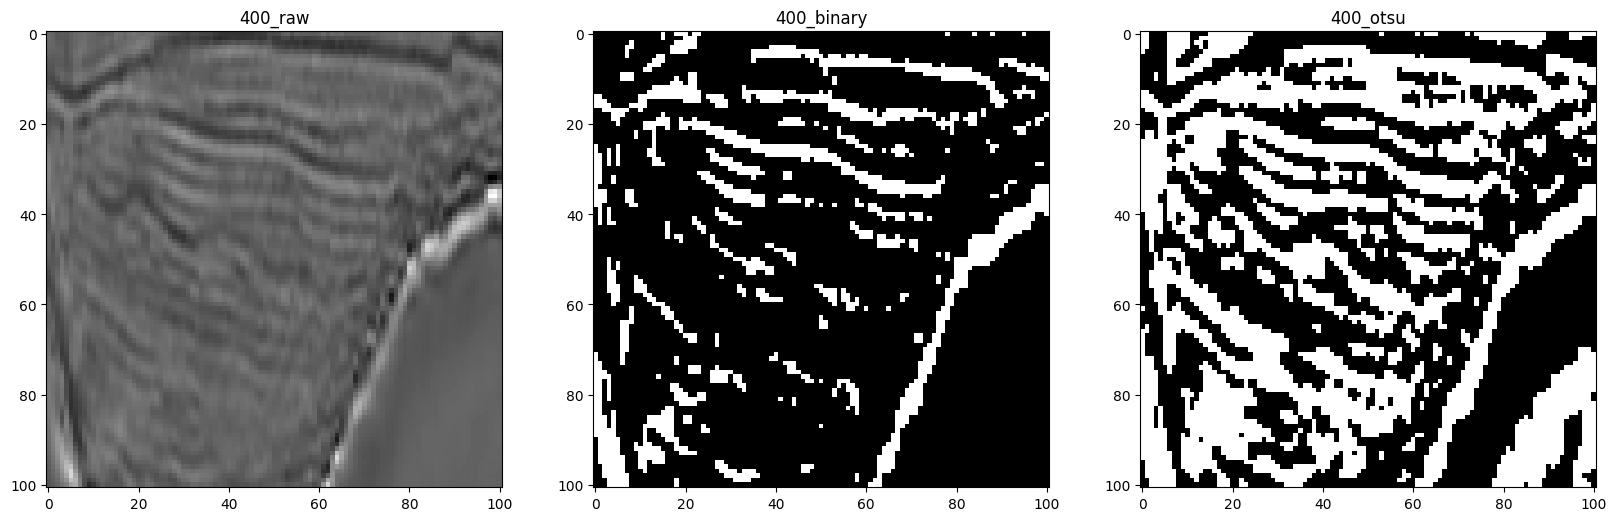

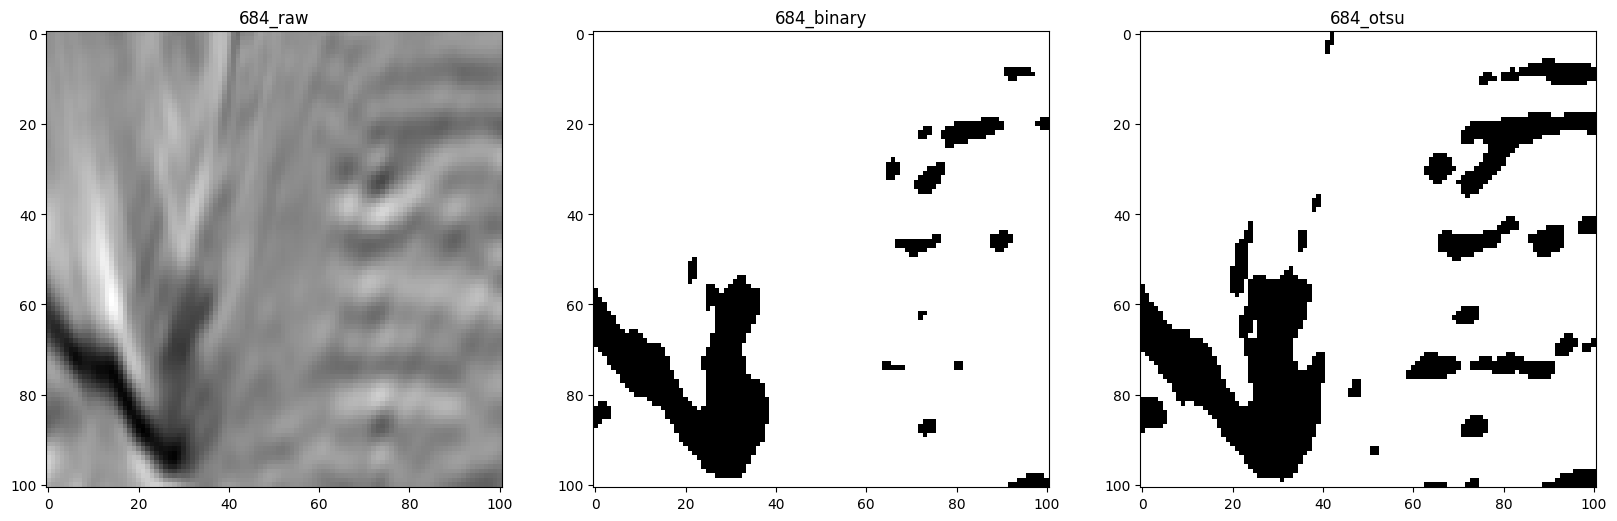

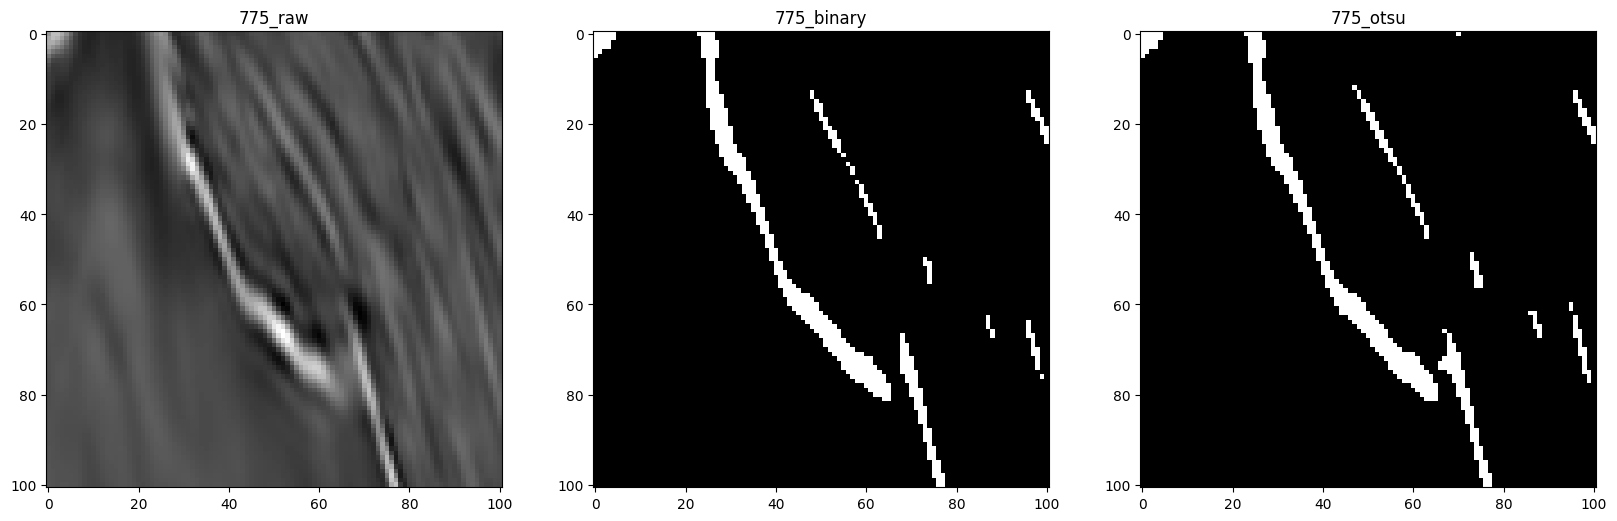

In [145]:
thresh = 110
for img_name in ids:
    plot_binary(img_name, thresh)

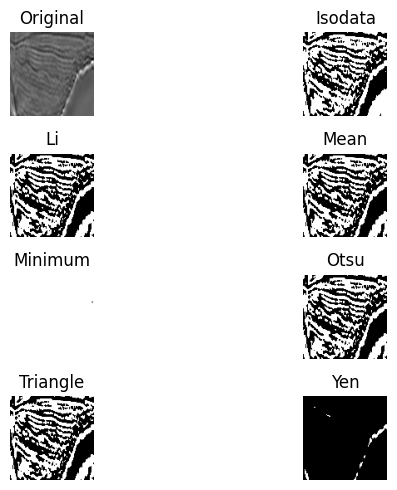

In [146]:
img = cv.imread(path_train + '/images/' + ids[2] + '.png',flags = cv.IMREAD_GRAYSCALE )
fig, ax = try_all_threshold(img, verbose = False)

* Histogram is not bipolar, so binary filter does not perform well
* Thresholding is not a good method to segment salt. But some boundaries can be identified

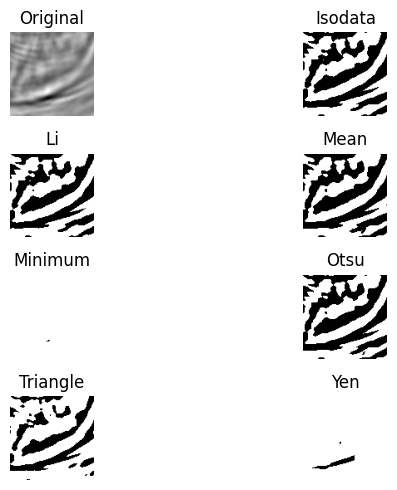

In [10]:
img = cv.imread(path_train + '/images/' + ids[3] + '.png',flags = cv.IMREAD_GRAYSCALE )
fig, ax = try_all_threshold(img, verbose = False)

In [74]:
# Apply edge detection filter
def edge_detection(img_name):
    img = cv.imread(path_train + '/images/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
#     mask = cv.imread(path_train + '/masks/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    edge_sobel = sobel(img)
    
    plt.figure(figsize=(6,3))
    
    plt.subplot(1,2,1)
    show_image(img, suffix =  '_raw')  
    
    plt.subplot(1,2,2)
    show_image(edge_sobel, suffix = '_sobel')  

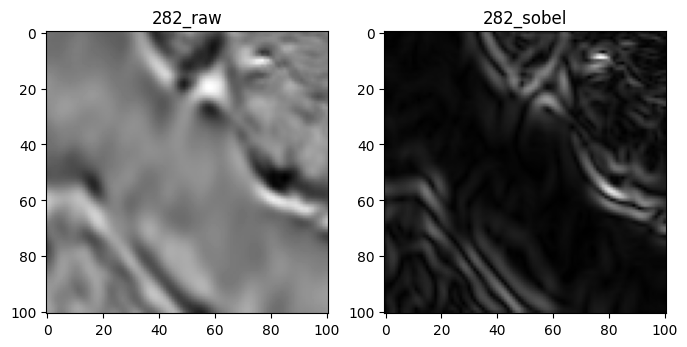

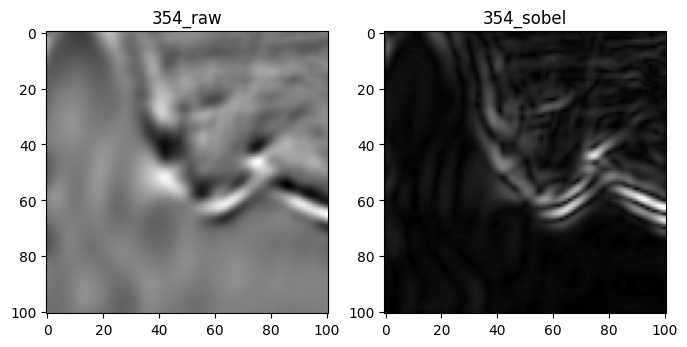

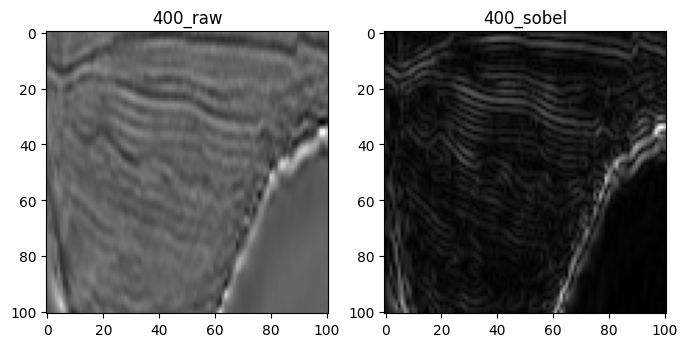

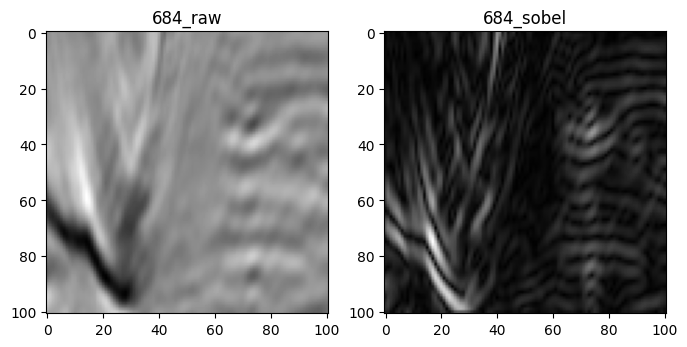

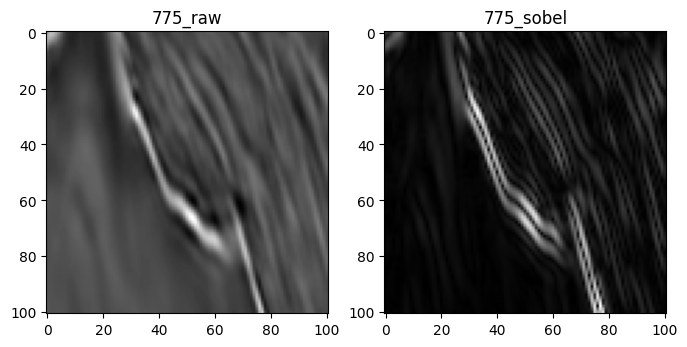

In [75]:
for img_name in ids:
    edge_detection(img_name)

In [129]:
def denoise_bl(img_name):
    """bilateral denoise to preserve edge while denoising"""
    img = cv.imread(path_train + '/images/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    denoised_img = denoise_bilateral(img, multichannel=False)
    gaussian_img = gaussian(img, channel_axis = 0)

    fig =  plt.figure(figsize=(20,10))
    
    plt.subplot(1,4,1)
    show_image(img, suffix =  '_raw')  
        
    ax1 = fig.add_subplot(1,4,2)
    ax1.hist(255*gaussian_img.ravel(), bins = 256)
    ax1.set_xlim(0, 255)
    ax1.set_ylim(ax1.get_ylim())
    ax1.set_title(str(z_df.loc[img_name,'z']) + '_gaussian_histogram') 
    ax1.set_aspect(1 / ax1.get_data_ratio())
    
    plt.subplot(1,4,3)
    show_image(denoised_img, suffix = '_bilateral')  
    
    ax3 = fig.add_subplot(1,4,4)
    ax3.hist(255*denoised_img.ravel(), bins = 256)
    ax3.set_xlim(0, 255)
    ax3.set_ylim(ax1.get_ylim())
    ax3.set_title(str(z_df.loc[img_name,'z']) + '_bilateral_histogram') 
    ax3.set_aspect(1 / ax3.get_data_ratio())

C:\Users\YX\AppData\Local\Temp\ipykernel_7036\577298980.py:4: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised_img = denoise_bilateral(img, multichannel=False)


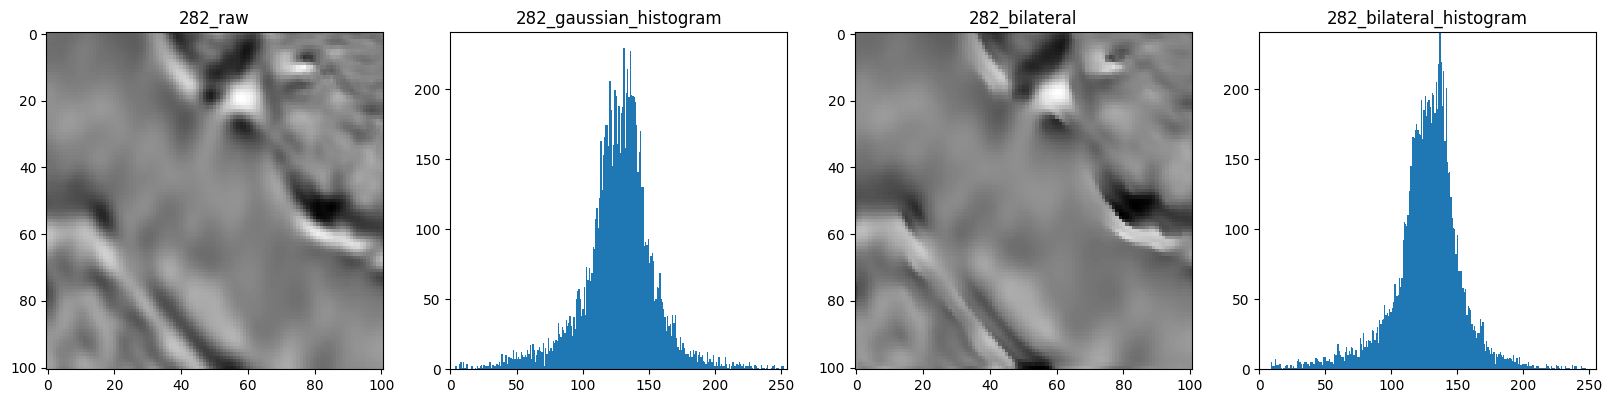

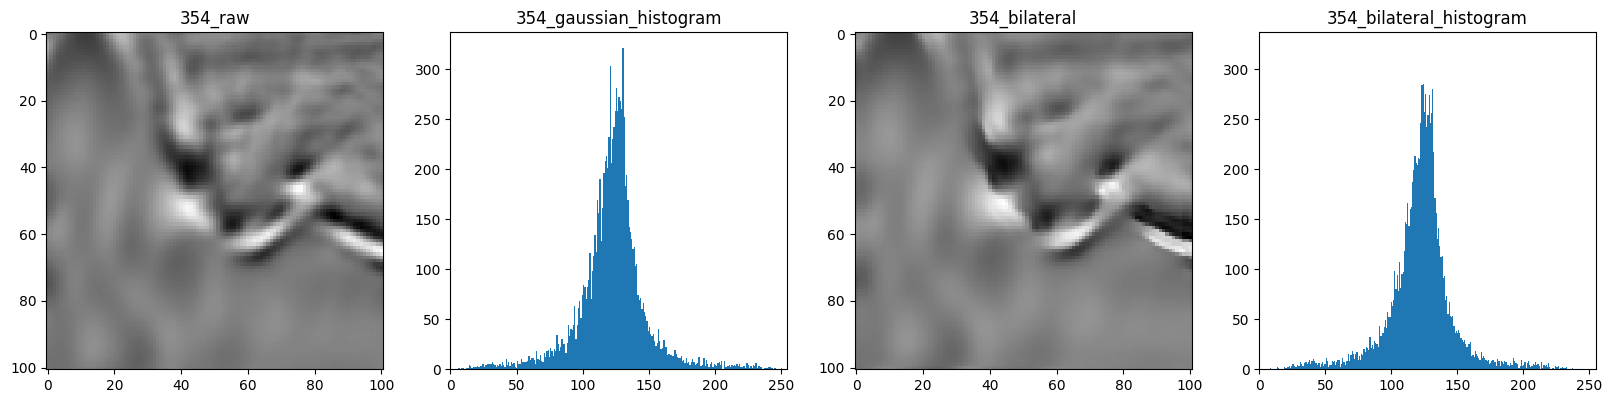

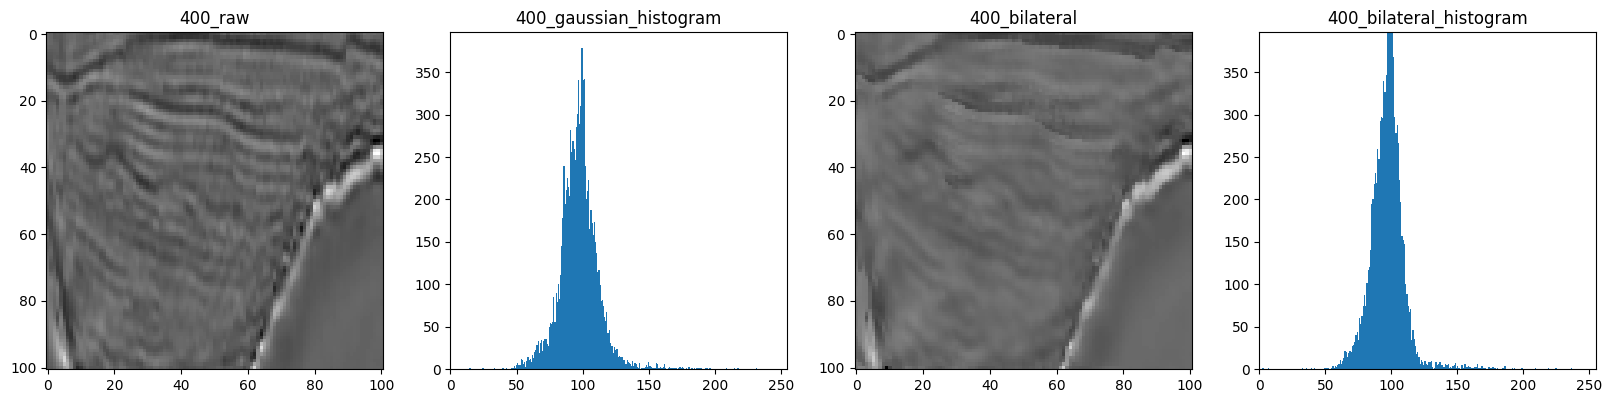

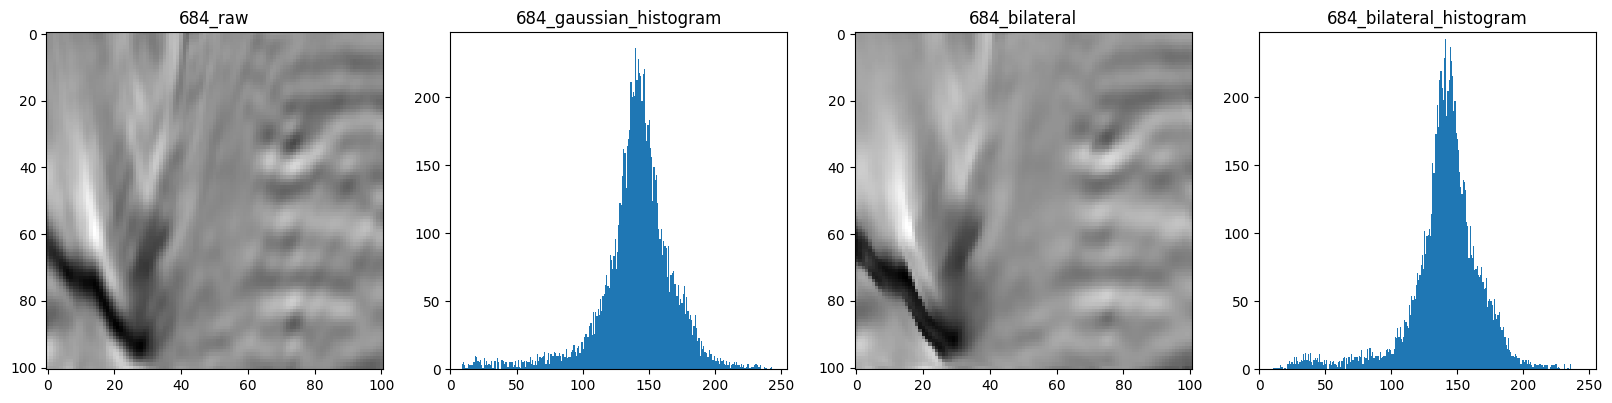

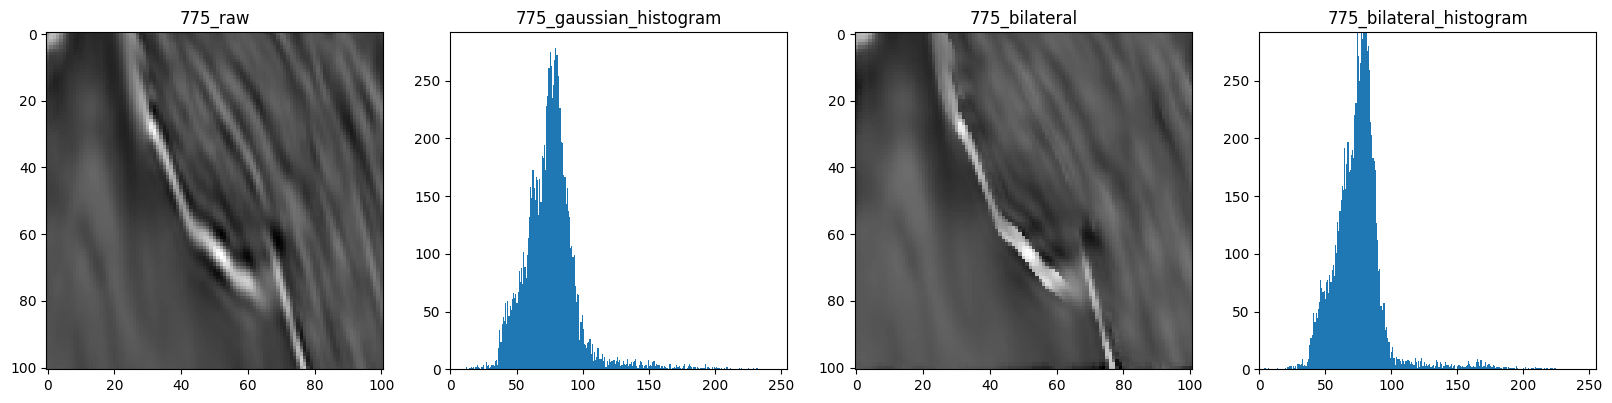

In [130]:
for img_name in ids:
    denoise_bl(img_name)

Bilateral filter removes local anormalies than Gaussian filter

In [135]:
def plot_slic(img_name, n_segments = 100):
    """unsupervised segmentation, simplie linear iterative clustering"""
    img = cv.imread(path_train + '/images/' + img_name + '.png',flags = cv.IMREAD_GRAYSCALE )
    segments = slic(img, n_segments = n_segments)
    
    # put segments on top of original image to compare
    segmented_img = label2rgb(segments, img, kind = 'avg')
    
    fig =  plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    show_image(img, suffix =  '_raw')  
    
    plt.subplot(1,2,2)
    show_image(segmented_img, suffix =  '_segmented')  

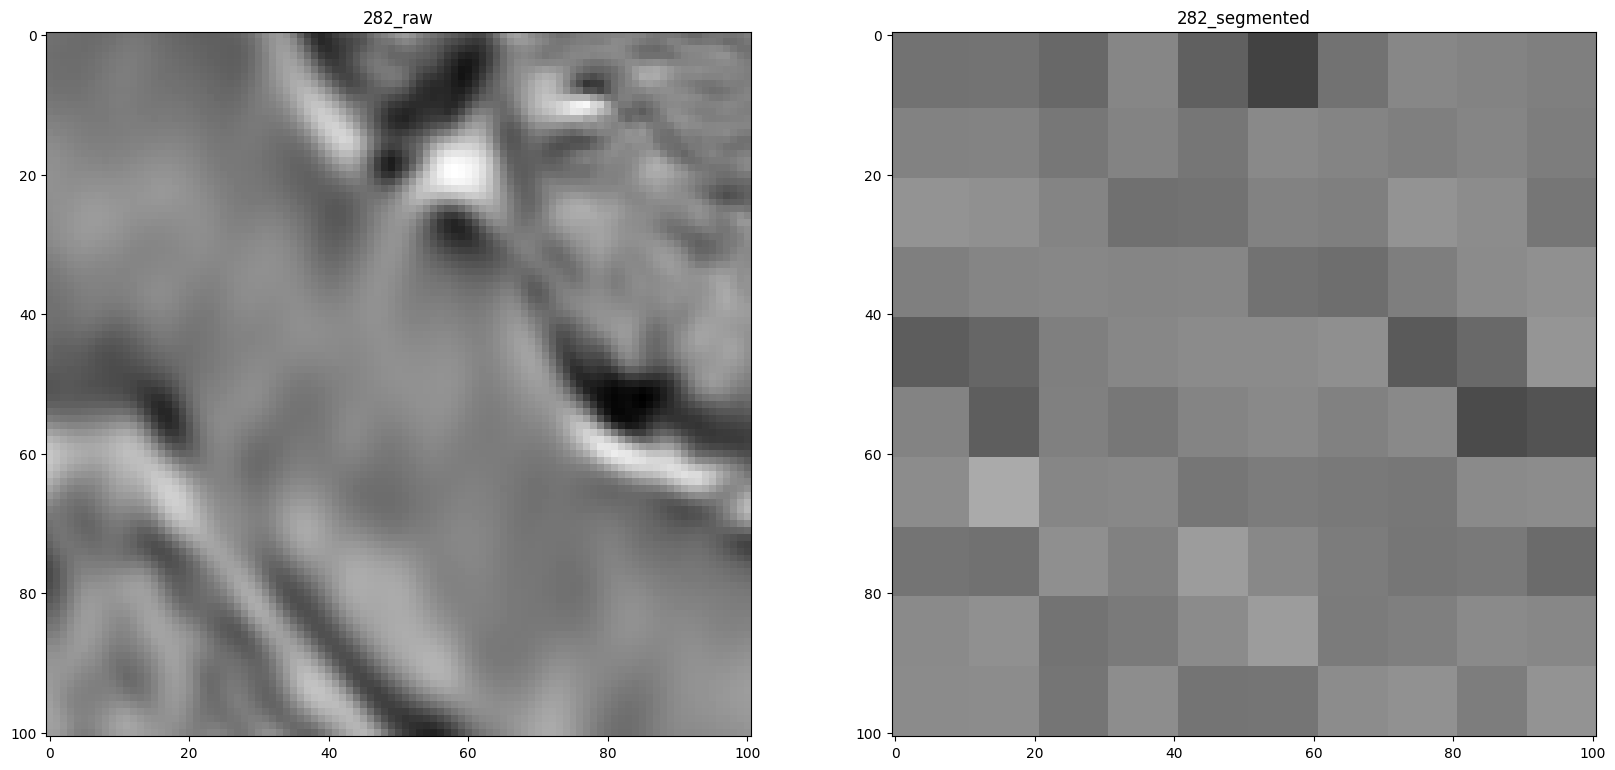

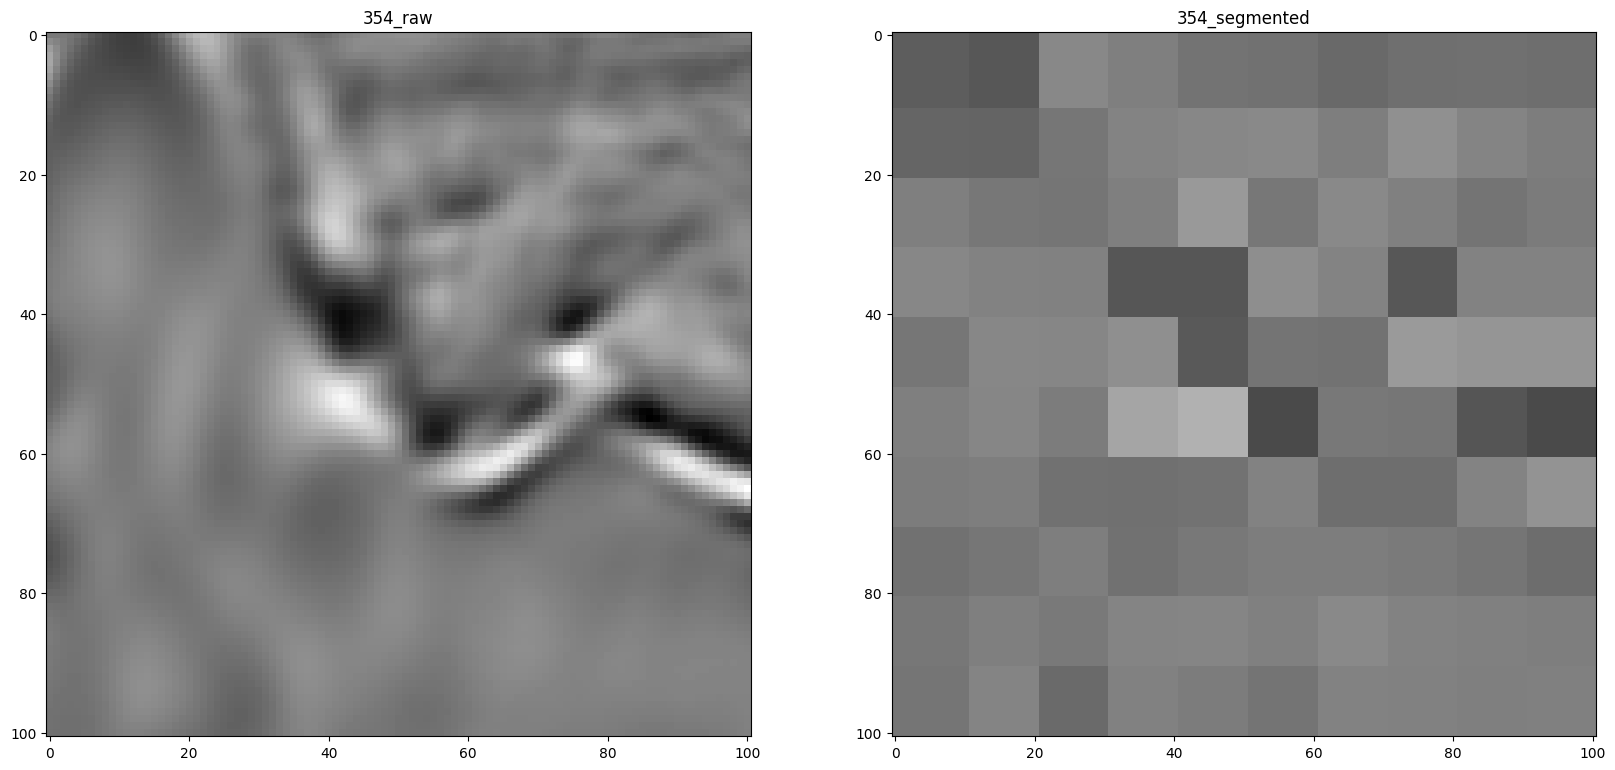

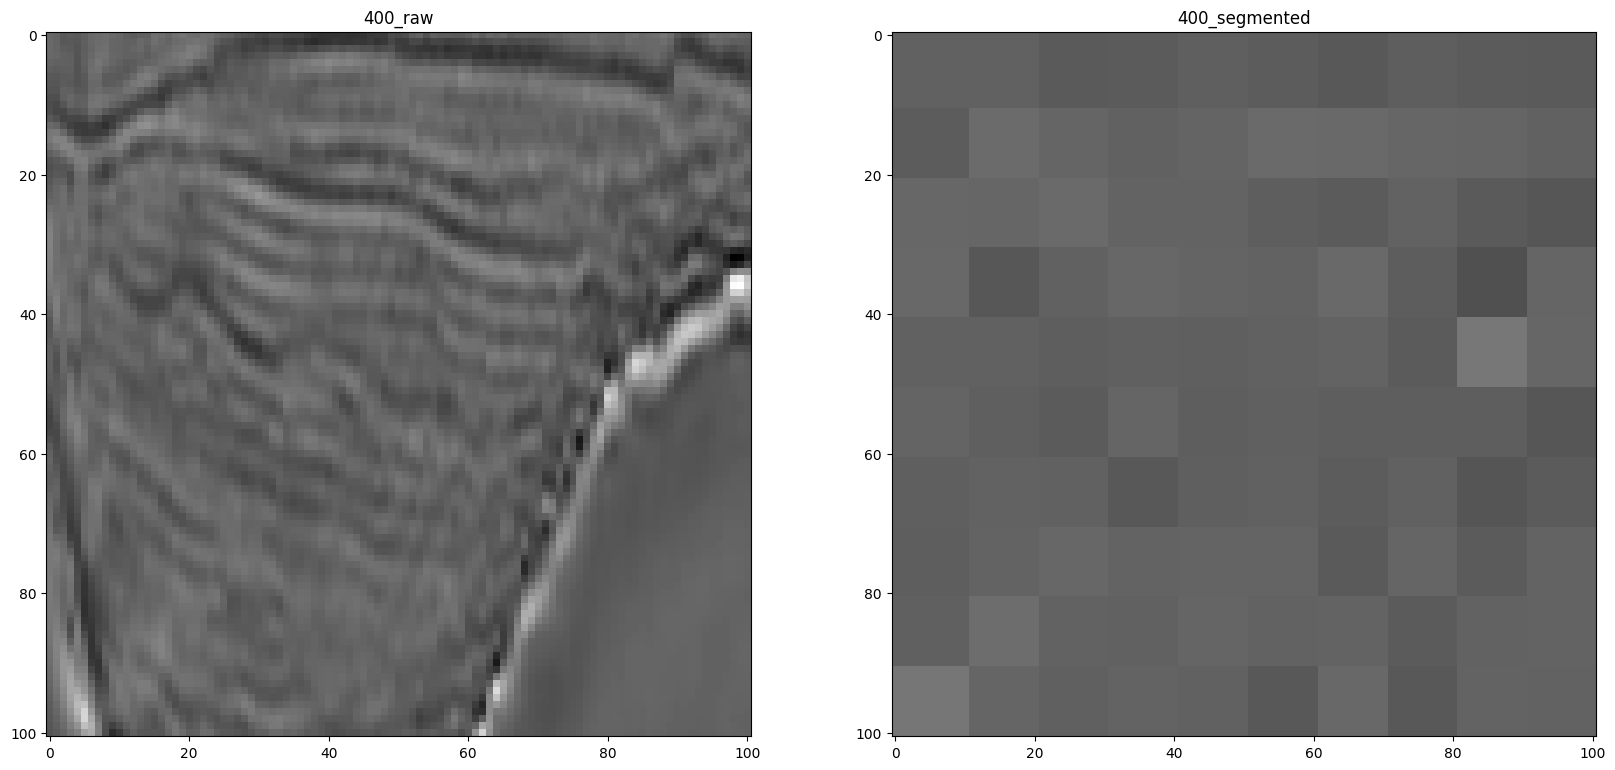

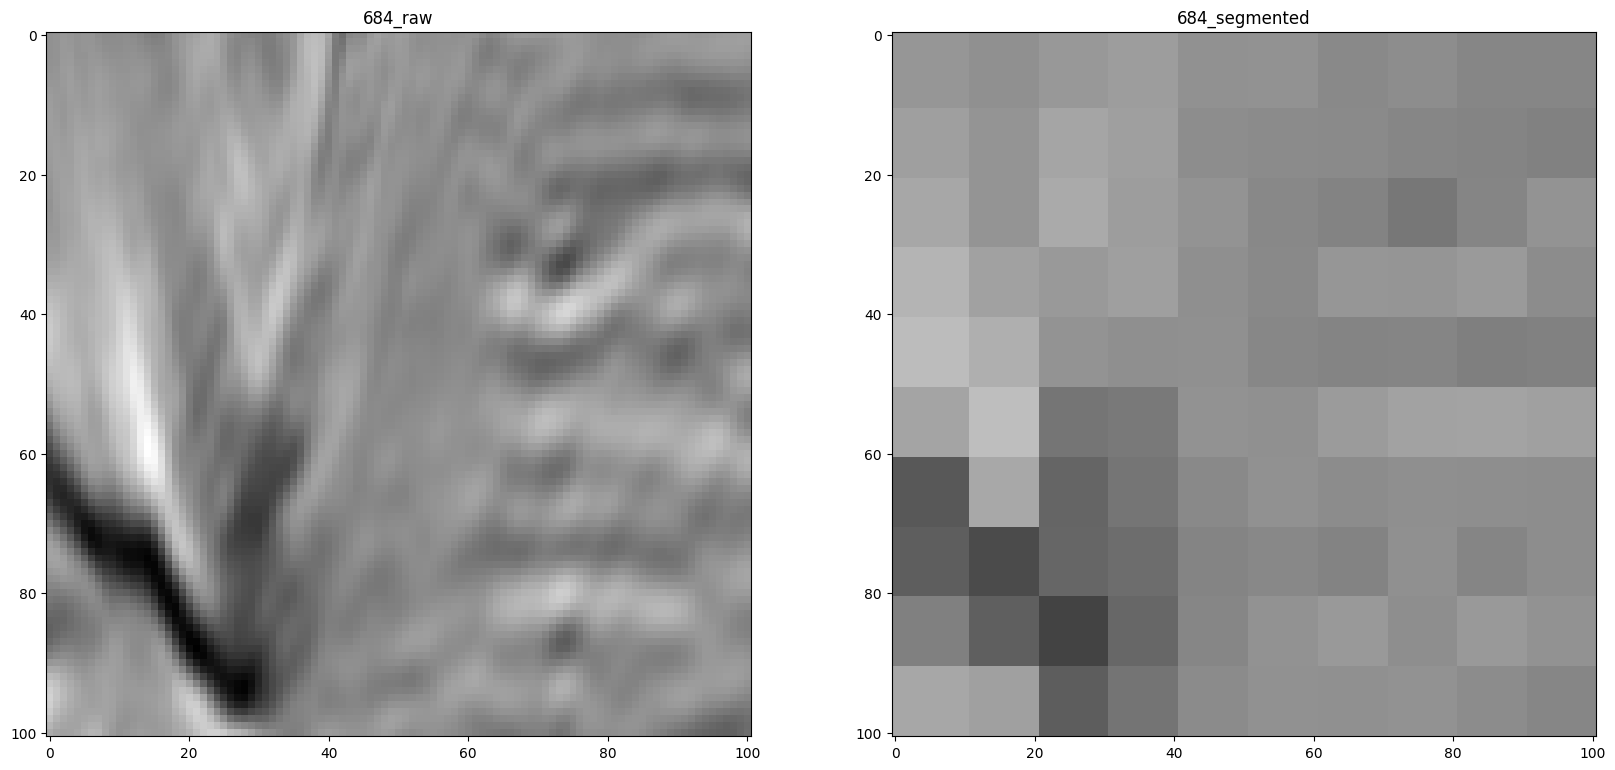

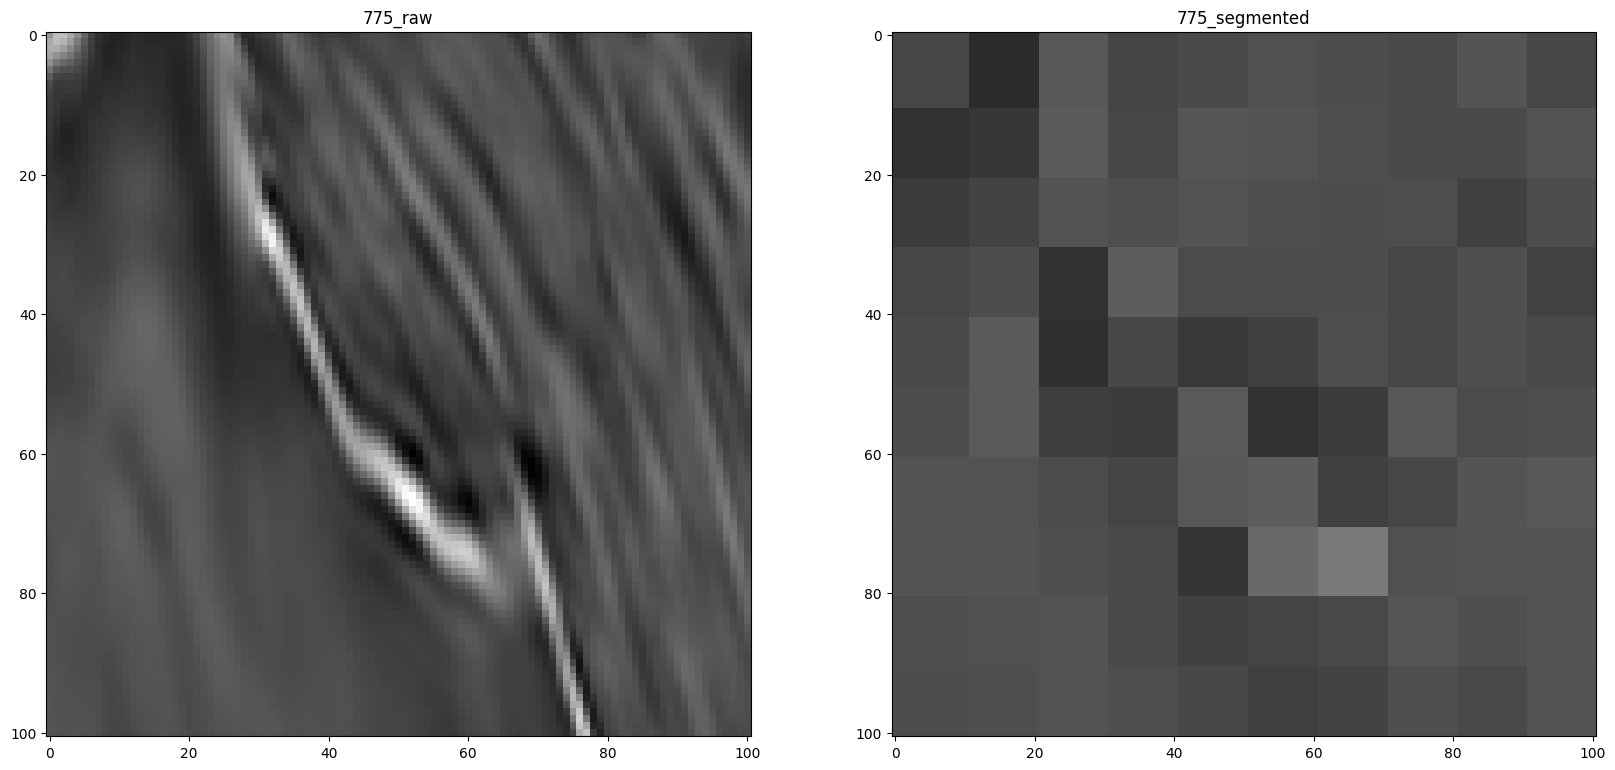

In [139]:
for img_name in ids:
    plot_slic(img_name)